# Example 13: Single Cell Killing Analysis

We define the T cell in contact that the cancer cell first reach CDI value 0.5 as the killer cell.

From this we store the killer T cell track ID and examine the accumulated contacts compare the result against cell kinematics.

This is a very complex running task and standalone python script is provided in [./example_13.py](./example_13.py) for background process.

In [1]:
import pandas as pd
import numpy as np
from cyto.postprocessing.sparse_to_sparse import *
import matplotlib.pyplot as plt
import seaborn as sns
from dask.distributed import Client
import dask.dataframe as dd
from tqdm import tqdm

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 251.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36593,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 251.55 GiB
Comm: tcp://127.0.0.1:37115,Total threads: 4
Dashboard: http://127.0.0.1:41317/status,Memory: 31.44 GiB
Nanny: tcp://127.0.0.1:34531,


## Data Loading

In [3]:
TCELL_DATA_PATH = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/plots/contact_analysis/Cyto/Tcell/track_tcell_merge_int_contact_ddf.csv"
CANCER_DATA_PATH = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/plots/contact_analysis/Cyto/Cancer/track_cancer_merge_int_contact_ddf.csv"

In [4]:
tcell_ddf = dd.read_csv(TCELL_DATA_PATH)
cancer_ddf = dd.read_csv(CANCER_DATA_PATH)

## Compute the Table for Necessary Values

In [5]:
tcell_ddf, tcell_ctfr_lp, tcell_ctfr_up = intensity_norm_percentile(tcell_ddf,channel="ctfr_mean", percentile=1)
tcell_ddf, tcell_pi_lp, tcell_pi_up = intensity_norm_percentile(tcell_ddf,channel="pi_mean", percentile=1)

In [ ]:
tcell_ddf.to_csv("./tmp/tcell.csv",index=False)

In [5]:
cancer_ddf, cancer_gfp_lp, cancer_gfp_up = intensity_norm_percentile(cancer_ddf,channel="gfp_mean", percentile=1)
cancer_ddf, cancer_pi_lp, cancer_pi_up = intensity_norm_percentile(cancer_ddf,channel="pi_mean", percentile=1)

In [ ]:
cancer_ddf = calculate_cdi(cancer_ddf, viability_col="gfp_mean_norm", death_col="pi_mean_norm")
cancer_ddf

In [ ]:
cancer_ddf = compute_savgol_filter(cancer_ddf, track_id_col='track_id', frame_col='frame', value_col='CDI', window_length=500, polyorder=3)
cancer_ddf

In [ ]:

cancer_ddf.to_csv("./tmp/cancer.csv",index=False)

### Shortcut to load pre computed data

In [3]:
tcell_ddf = dd.read_csv("./tmp/tcell.csv/*.part")
cancer_ddf = dd.read_csv("./tmp/cancer.csv/*.part")

In [4]:
tcell_df = tcell_ddf.compute()
cancer_df = cancer_ddf.compute()

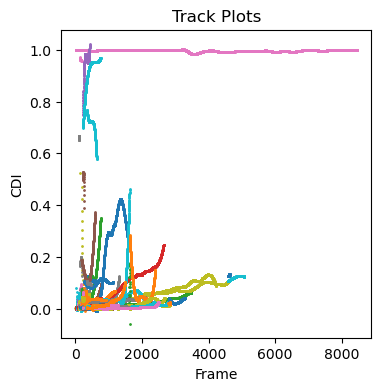

In [5]:
fig, axs = plt.subplots(1,1,figsize=(4,4))

axs.set_title("Track Plots")
axs.set_xlabel("Frame")
axs.set_ylabel("CDI")

for i in range(500):
    axs.scatter(cancer_df[cancer_df["track_id"]==i]["frame"],cancer_df[cancer_df["track_id"]==i]["CDI_smoothed"],s=1)

## Match CDI of Cancer Cells to Back Trace T Cells in Contact

### Single Killer for One Death Event

In [70]:
def identify_killer_t_cell(df, cdi_thres=0.5):
    # Step1: Filter out cells with lower CDI values, to keep only live cells in the df
    df_filtered = df.groupby('track_id').filter(lambda x: ((x['CDI_smoothed'] > 0) & (x['CDI_smoothed'] < cdi_thres)).any())
    
    # Step 2: Filter for rows where 'value' is greater than or equal to cdi_thres
    df_filtered = df_filtered[df_filtered['CDI_smoothed'] >= cdi_thres]

    # Step 3: Group by 'track_id' and get the first occurrence of 'frame' for each group
    first_frame = df_filtered.sort_values(by=['frame']).groupby('track_id').first().reset_index()

    # Step 4: Extract the 'track_id' and 'frame' columns
    result = first_frame[['track_id', 'frame', 'contacting cell labels']]

    return result

In [71]:
killer_t_cells = {}

# iterate over different CDI thresholds
for i in tqdm(range(2,9,1)):
    cdi_thres = 0.1*i

    killer_t_cells_ = identify_killer_t_cell(cancer_df,cdi_thres)
    killer_t_cells[cdi_thres] = killer_t_cells_

    # save the killer t cell df
    killer_t_cells_.to_csv("./tmp/killer_t_cells_{:.1f}.csv".format(cdi_thres),index=False)

100%|██████████| 7/7 [04:29<00:00, 38.57s/it]


### Multiple Killers for One Death Event

In [72]:
def identify_multi_killer_t_cell(df,cdi_thres_lower=0.2,cdi_thres_upper=0.8):
    # Step1: Filter out cells with lower CDI values, to keep only live cells in the df
    df_filtered = df.groupby('track_id').filter(lambda x: ((x['CDI_smoothed'] > 0) & (x['CDI_smoothed'] < cdi_thres_lower)).any())
    
    # Step 2: Filter for rows where 'value' is within the cdi_thres bound
    df_filtered = df_filtered[(df_filtered['CDI_smoothed'] >= cdi_thres_lower) & (df_filtered['CDI_smoothed'] <= cdi_thres_upper)]

    # Step 3: Extract the 'track_id' and 'frame' columns
    result = df_filtered[['track_id', 'frame', 'contacting cell labels']]

    return result

In [73]:
multi_killer_t_cells = {}

# iterate over different CDI thresholds
for i in tqdm(range(2,5,1)):
    cdi_thres_lower = 0.1*i
    cdi_thres_upper = 1- 0.1*i
    multi_killer_t_cells_ = identify_multi_killer_t_cell(cancer_df,cdi_thres_lower=cdi_thres_lower,cdi_thres_upper=cdi_thres_upper)

    # save the multiple killer t cell df
    multi_killer_t_cells_.to_csv("./tmp/multi_killer_t_cells_{:.1f}.csv".format(cdi_thres_lower),index=False)

100%|██████████| 3/3 [01:55<00:00, 38.54s/it]


### Shortcut to load pre computed data

In [6]:
killer_t_cells = {}

for i in tqdm(range(2,9,1)):
    cdi_thres = 0.1*i
    killer_t_cells[cdi_thres] = dd.read_csv("./tmp/killer_t_cells_{:.1f}.csv".format(cdi_thres))
    killer_t_cells[cdi_thres] = killer_t_cells[cdi_thres].compute()
killer_t_cells[0.5]

100%|██████████| 7/7 [00:00<00:00, 32.47it/s]


,track_id,frame,contacting cell labels
0,158,139,[111785 111892 113022 113279 113513]
1,495,224,[120827]
2,528,346,[50357]
3,577,406,[13195]
4,610,6362,[172517 174841 175097]
...,...,...,...
15111,208478,8188,[121686 121925 121960 124903]
15112,208493,8374,[237578 238969]
15113,208506,8446,[203085 203259 204026]
15114,208514,8422,[95977 97157 97573 97670 99474]


In [7]:
multi_killer_t_cells = {}

for i in tqdm(range(2,5,1)):
    cdi_thres = 0.1*i
    multi_killer_t_cells[cdi_thres] = dd.read_csv("./tmp/multi_killer_t_cells_{:.1f}.csv".format(cdi_thres))
    multi_killer_t_cells[cdi_thres] = multi_killer_t_cells[cdi_thres].compute()
multi_killer_t_cells[0.2]

100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


,track_id,frame,contacting cell labels
0,27540,2455,[178197 178697]
1,150764,4513,[125805 125883]
2,148504,4749,[111270 111429]
3,66069,4937,[215121 216457]
4,134220,5572,[205333]
...,...,...,...
2723452,52370,3408,[168706]
2723453,67913,4894,[53551]
2723454,169080,5360,[]
2723455,189360,6820,[84885]


Text(0.5, 1.0, 'Cell ID: 1685')

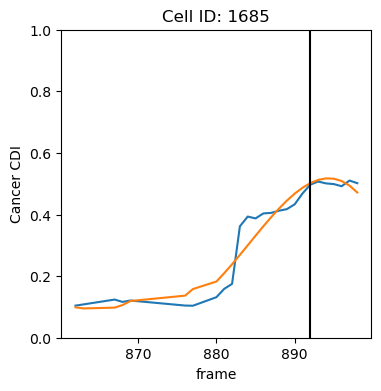

In [8]:
killer_id = 10 #FAST:10,38; SLOW: 20,40

track_id = killer_t_cells[0.5]["track_id"][killer_id]

track = cancer_df[cancer_df["track_id"]==track_id]
track = track.sort_values(by=["frame"])

fig, axs = plt.subplots(1,1,figsize=(4,4))

axs.plot(track["frame"],track["CDI"])
axs.plot(track["frame"],track["CDI_smoothed"])
axs.axvline(killer_t_cells[0.5]["frame"][killer_id], c="k", label="Killing Event")
axs.set_xlabel("frame")
axs.set_ylabel("Cancer CDI")
axs.set_ylim(0,1)
axs.set_title("Cell ID: {}".format(track_id))

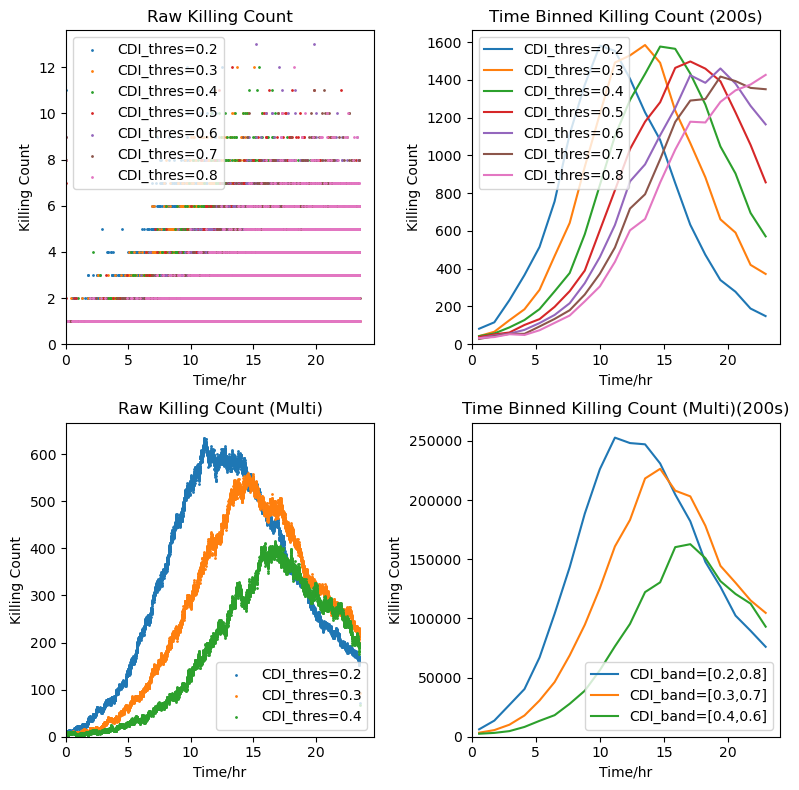

In [9]:
# plot the killing time
fig, axs = plt.subplots(2,2,figsize=(8,8))

######### single killer #########
axs[0,0].set_title("Raw Killing Count")
axs[0,0].set_ylabel("Killing Count")
axs[0,0].set_xlabel("Time/hr")

# binned plot
num_bins = 20
axs[0,1].set_title("Time Binned Killing Count ({}s)".format(num_bins*10))
axs[0,1].set_ylabel("Killing Count")
axs[0,1].set_xlabel("Time/hr")

for i in range(2,9,1):
    cdi_thres = i*0.1
    killing_count = killer_t_cells[cdi_thres].groupby("frame")["track_id"].count()

    axs[0,0].scatter(killing_count.index*10/3600, killing_count, s=1, label="CDI_thres={:.1f}".format(cdi_thres))

    # Bin the x-values
    bins = pd.cut(killing_count.index, bins=num_bins)

    # Group by the bins and sum the y-values for each bin
    binned_data = killing_count.groupby(bins).sum()

    # Compute the midpoints of each bin for plotting
    bin_centers = binned_data.index.map(lambda interval: interval.mid)
    axs[0,1].plot(bin_centers.to_numpy()*10/3600, binned_data, label="CDI_thres={:.1f}".format(cdi_thres))

axs[0,0].set_xlim(left=0)
axs[0,0].set_ylim(bottom=0)
axs[0,1].set_xlim(left=0)
axs[0,1].set_ylim(bottom=0)

axs[0,0].legend()
axs[0,1].legend()

######### multi killer #########
axs[1,0].set_title("Raw Killing Count (Multi)")
axs[1,0].set_ylabel("Killing Count")
axs[1,0].set_xlabel("Time/hr")

# binned plot
axs[1,1].set_title("Time Binned Killing Count (Multi)({}s)".format(num_bins*10))
axs[1,1].set_ylabel("Killing Count")
axs[1,1].set_xlabel("Time/hr")

for i in range(2,5,1):
    cdi_thres = 0.1*i

    multi_killing_count = multi_killer_t_cells[cdi_thres].groupby("frame")["track_id"].count()

    axs[1,0].scatter(multi_killing_count.index*10/3600, multi_killing_count, s=1, label="CDI_thres={:.1f}".format(cdi_thres))

    # Bin the x-values
    bins = pd.cut(multi_killing_count.index, bins=num_bins)

    # Group by the bins and sum the y-values for each bin
    binned_data = multi_killing_count.groupby(bins).sum()

    # Compute the midpoints of each bin for plotting
    bin_centers = binned_data.index.map(lambda interval: interval.mid)
    axs[1,1].plot(bin_centers.to_numpy()*10/3600, binned_data, label="CDI_band=[{:.1f},{:.1f}]".format(cdi_thres,1-cdi_thres))

axs[1,0].set_xlim(left=0)
axs[1,0].set_ylim(bottom=0)
axs[1,1].set_xlim(left=0)
axs[1,1].set_ylim(bottom=0)

axs[1,0].legend()
axs[1,1].legend()

fig.tight_layout()

### Put Killing Event Tag to The T Cell Dataframe

In [10]:
contacts = {}
for i in tqdm(range(2,9,1)):
    cdi_thres = i*0.1

    contacts_dict = {
        "frame": [],
        "label": [],
        "kill": []
    }

    for idx, row in killer_t_cells[cdi_thres].iterrows():
        tcells = row["contacting cell labels"]
        tcells = tcells.strip('[]')

        for j in tcells.split():
            contacts_dict["frame"].append(row["frame"])
            contacts_dict["label"].append(int(j))        
            contacts_dict["kill"].append(True)

    contacts[cdi_thres] = pd.DataFrame.from_dict(contacts_dict)
contacts[0.5]

100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


,frame,label,kill
0,139,111785,True
1,139,111892,True
2,139,113022,True
3,139,113279,True
4,139,113513,True
...,...,...,...
39493,8422,97157,True
39494,8422,97573,True
39495,8422,97670,True
39496,8422,99474,True


In [11]:
multi_contacts = {}
for i in tqdm(range(2,5,1)):
    cdi_thres = i*0.1

    multi_contacts_dict = {
        "frame": [],
        "label": [],
        "kill": []
    }

    for idx, row in multi_killer_t_cells[cdi_thres].iterrows():
        tcells = row["contacting cell labels"]
        tcells = tcells.strip('[]')

        for j in tcells.split():
            multi_contacts_dict["frame"].append(row["frame"])
            multi_contacts_dict["label"].append(int(j))        
            multi_contacts_dict["kill"].append(True)

    multi_contacts[cdi_thres] = pd.DataFrame.from_dict(multi_contacts_dict)
multi_contacts[0.2]

100%|██████████| 3/3 [03:10<00:00, 63.33s/it]


,frame,label,kill
0,2455,178197,True
1,2455,178697,True
2,4513,125805,True
3,4513,125883,True
4,4749,111270,True
...,...,...,...
5189559,3408,168706,True
5189560,4894,53551,True
5189561,6820,84885,True
5189562,3348,239070,True


In [12]:
t_cell_counts = tcell_ddf.groupby("frame")["track_id"].count().cumsum()
t_cell_counts = t_cell_counts.compute()
t_cell_counts

frame
0           3834
1           7659
2          11472
3          15303
4          19128
          ...   
8474    23582647
8475    23586261
8476    23589882
8477    23593513
8478    23595270
Name: track_id, Length: 8479, dtype: int64

In [13]:
# offset the label id by time
for i in range(2,9,1):
    cdi_thres = 0.1*i
    contacts[cdi_thres]['label'] = contacts[cdi_thres].apply(lambda x: x["label"] + t_cell_counts[x["frame"]], axis=1)
contacts[0.5]

,frame,label,kill
0,139,383207,True
1,139,383314,True
2,139,384444,True
3,139,384701,True
4,139,384935,True
...,...,...,...
39493,8422,23491218,True
39494,8422,23491634,True
39495,8422,23491731,True
39496,8422,23493535,True


In [17]:
# offset the label id by time for multi killers
for i in range(2,5,1):
    cdi_thres = 0.1*i
    multi_contacts[cdi_thres]['label'] = multi_contacts[cdi_thres].apply(lambda x: x["label"] + t_cell_counts[x["frame"]], axis=1)
multi_contacts[0.2]

,frame,label,kill
0,2455,4830012,True
1,2455,4830512,True
2,4513,10446562,True
3,4513,10446640,True
4,4749,11138935,True
...,...,...,...
5189559,3408,7304031,True
5189560,4894,11517112,True
5189561,6820,17801169,True
5189562,3348,7209038,True


In [14]:
tcell_with_kill = {}
for i in tqdm(range(2,9,1)):
    cdi_thres = 0.1*i

    tcell_with_kill[cdi_thres] = dd.merge(tcell_ddf,contacts[cdi_thres][["kill","label"]], on=["label"], how="left")
    tcell_with_kill[cdi_thres] = tcell_with_kill[cdi_thres].compute()
    tcell_with_kill[cdi_thres]['kill'] = tcell_with_kill[cdi_thres]['kill'].fillna(False)
tcell_with_kill[0.5]

100%|██████████| 7/7 [02:36<00:00, 22.41s/it]


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,mean tracked cell size,ctfr_mean,ctfr_median,ctfr_sd,closest cell dist,contact,contacting cell labels,ctfr_mean_norm,pi_mean_norm,kill
0,23506300,858.538462,236.400000,233,854,8,11,236.400000,858.538462,233.0,...,70.276939,176.907692,170.613281,46.081356,1.278615,True,[125845 126247 128438],0.046086,0.663729,False
1,23538897,431.114583,745.031250,740,425,10,13,745.031250,431.114583,740.0,...,96.497207,197.677083,181.884766,87.373909,2.257658,True,[154477 155484 156668],0.065297,0.187571,False
2,23567508,793.029557,991.211823,982,785,18,16,991.211823,793.029557,982.0,...,91.668539,283.083744,236.503906,132.560346,4.948832,True,[178131 178237],0.144295,0.921509,False
3,23622464,609.587629,245.000000,240,605,11,11,245.000000,609.587629,240.0,...,90.530528,133.309278,110.714844,9.515733,0.417839,True,[224965],0.005759,0.216690,False
4,23639053,702.212389,738.796460,733,696,11,14,738.796460,702.212389,733.0,...,96.565789,151.637168,124.521484,16.637985,2.199979,True,[237891],0.022711,0.590100,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149309,25536488,393.279070,69.976744,67,389,7,9,69.976744,393.279070,67.0,...,48.211568,242.000000,228.626953,73.172334,2.582023,True,[122932],0.106294,0.013658,False
149310,25550106,14.000000,196.000000,194,12,5,5,196.000000,14.000000,194.0,...,31.588235,232.000000,255.275391,37.811374,5.537556,True,[134641 134642],0.097044,0.016048,False
149311,25578560,335.098039,216.294118,213,330,7,10,216.294118,335.098039,213.0,...,51.037634,136.529412,134.843750,10.462032,2.111787,True,[157757 160683],0.008737,0.155278,False
149312,25585404,519.011236,707.191011,702,515,13,9,707.191011,519.011236,702.0,...,73.827160,368.393258,315.595703,195.640476,5.555626,True,[164636 165154],0.223203,0.027446,False


In [18]:
tcell_with_multi_kill = {}
for i in tqdm(range(2,5,1)):
    cdi_thres = 0.1*i

    tcell_with_multi_kill[cdi_thres] = dd.merge(tcell_ddf,multi_contacts[cdi_thres][["kill","label"]], on=["label"], how="left")
    tcell_with_multi_kill[cdi_thres] = tcell_with_multi_kill[cdi_thres].compute()
    tcell_with_multi_kill[cdi_thres]['kill'] = tcell_with_multi_kill[cdi_thres]['kill'].fillna(False)
tcell_with_multi_kill[0.2]

100%|██████████| 3/3 [01:50<00:00, 36.83s/it]


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,mean tracked cell size,ctfr_mean,ctfr_median,ctfr_sd,closest cell dist,contact,contacting cell labels,ctfr_mean_norm,pi_mean_norm,kill
0,23506300,858.538462,236.400000,233,854,8,11,236.400000,858.538462,233.0,...,70.276939,176.907692,170.613281,46.081356,1.278615,True,[125845 126247 128438],0.046086,0.663729,False
1,23538897,431.114583,745.031250,740,425,10,13,745.031250,431.114583,740.0,...,96.497207,197.677083,181.884766,87.373909,2.257658,True,[154477 155484 156668],0.065297,0.187571,False
2,23567508,793.029557,991.211823,982,785,18,16,991.211823,793.029557,982.0,...,91.668539,283.083744,236.503906,132.560346,4.948832,True,[178131 178237],0.144295,0.921509,False
3,23622464,609.587629,245.000000,240,605,11,11,245.000000,609.587629,240.0,...,90.530528,133.309278,110.714844,9.515733,0.417839,True,[224965],0.005759,0.216690,False
4,23639053,702.212389,738.796460,733,696,11,14,738.796460,702.212389,733.0,...,96.565789,151.637168,124.521484,16.637985,2.199979,True,[237891],0.022711,0.590100,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153248,25536488,393.279070,69.976744,67,389,7,9,69.976744,393.279070,67.0,...,48.211568,242.000000,228.626953,73.172334,2.582023,True,[122932],0.106294,0.013658,False
153249,25550106,14.000000,196.000000,194,12,5,5,196.000000,14.000000,194.0,...,31.588235,232.000000,255.275391,37.811374,5.537556,True,[134641 134642],0.097044,0.016048,False
153250,25578560,335.098039,216.294118,213,330,7,10,216.294118,335.098039,213.0,...,51.037634,136.529412,134.843750,10.462032,2.111787,True,[157757 160683],0.008737,0.155278,False
153251,25585404,519.011236,707.191011,702,515,13,9,707.191011,519.011236,702.0,...,73.827160,368.393258,315.595703,195.640476,5.555626,True,[164636 165154],0.223203,0.027446,False


## Plotting

### Merging Killing Events to T Cell DF

In [20]:
tcell_killing = {}

for i in tqdm(range(2,9,1)):
    cdi_thres = 0.1*i
    tcell_killing[cdi_thres] = tcell_with_kill[cdi_thres][tcell_with_kill[cdi_thres]["kill"]]
tcell_killing[0.5]

100%|██████████| 7/7 [00:00<00:00, 60.42it/s]


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,mean tracked cell size,ctfr_mean,ctfr_median,ctfr_sd,closest cell dist,contact,contacting cell labels,ctfr_mean_norm,pi_mean_norm,kill
1014,15797544,345.060606,861.863636,858,341,9,9,861.863636,345.060606,858.0,...,60.157895,137.393939,151.865234,10.468824,0.452191,True,[145105 146397],0.009537,0.133913,True
2026,15028702,115.810345,277.586207,273,112,10,8,277.586207,115.810345,273.0,...,61.544066,135.241379,152.421875,9.454063,0.055889,True,[1862 3013],0.007546,0.140038,True
2479,22220044,537.735294,104.000000,101,535,7,6,104.000000,537.735294,101.0,...,41.684637,283.941176,243.453125,123.457008,9.365353,True,[160096],0.145088,0.014782,True
3110,1740480,121.564103,524.205128,521,119,7,7,524.205128,121.564103,521.0,...,40.373016,246.410256,220.816406,116.353300,6.238581,True,[206291 206574],0.110373,0.000472,True
4006,22161197,863.983333,710.116667,706,860,9,9,710.116667,863.983333,706.0,...,55.126876,137.016667,145.615234,9.441150,1.214161,True,[112526 112527],0.009188,0.199961,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145593,6760697,647.188889,852.544444,848,642,10,11,852.544444,647.188889,848.0,...,87.681818,486.633333,358.326172,318.966747,7.986900,True,[50158 50476],0.332571,0.009504,True
145625,9237829,674.155556,506.377778,502,671,9,8,506.377778,674.155556,502.0,...,94.200000,316.200000,260.250000,148.513636,4.017539,True,[84223 86713],0.174926,0.038985,True
146002,16077805,308.000000,202.000000,199,304,7,9,202.000000,308.000000,199.0,...,52.076336,132.816327,118.806641,7.873144,1.989818,True,[116203 117292],0.005303,0.050516,True
146743,4943714,581.190476,966.642857,964,578,6,8,966.642857,581.190476,964.0,...,59.349793,404.333333,322.970703,241.110203,3.508371,True,[277620 279114],0.256446,0.004818,True


In [21]:
tcell_multi_killing = {}

for i in tqdm(range(2,5,1)):
    cdi_thres = 0.1*i
    tcell_multi_killing[cdi_thres] = tcell_with_multi_kill[cdi_thres][tcell_with_multi_kill[cdi_thres]["kill"]]
tcell_multi_killing[0.2]

100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,mean tracked cell size,ctfr_mean,ctfr_median,ctfr_sd,closest cell dist,contact,contacting cell labels,ctfr_mean_norm,pi_mean_norm,kill
6,23685408,710.576923,599.336538,593,705,13,12,599.336538,710.576923,593.0,...,96.410506,132.269231,128.761719,9.794223,0.620393,True,[276891 277604],0.004797,0.196119,True
16,23214750,789.523077,273.523077,269,786,10,8,273.523077,789.523077,269.0,...,66.555106,220.276923,168.460938,92.614879,0.469682,True,[162742],0.086201,0.177577,True
323,769153,669.162791,38.046512,35,666,8,7,38.046512,669.162791,35.0,...,33.473684,321.395349,336.640625,134.811003,17.825117,False,[],0.179732,0.000281,True
334,1024483,371.666667,473.793651,470,368,10,9,473.793651,371.666667,470.0,...,42.058252,648.650794,472.027344,420.671589,7.940577,True,[154469],0.482431,0.001406,True
349,2804719,36.647059,226.333333,223,33,8,8,226.333333,36.647059,223.0,...,53.760204,210.450980,200.283203,64.387674,5.670977,True,[93830],0.077112,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153139,23741439,772.153846,718.215385,713,768,12,9,718.215385,772.153846,713.0,...,95.607477,138.400000,119.638672,11.145066,2.782419,True,[41912],0.010468,0.343059,True
153148,22491969,437.943662,250.098592,245,434,11,9,250.098592,437.943662,245.0,...,89.930328,141.422535,152.285156,15.189905,0.796025,True,[111789 112787],0.013263,0.221799,True
153151,22559116,162.553571,309.607143,306,159,8,9,309.607143,162.553571,306.0,...,44.384615,134.214286,117.080078,7.576793,4.181886,True,[166230 166279 167650],0.006596,0.168347,True
153179,23541546,679.324324,984.513514,981,676,7,8,984.513514,679.324324,981.0,...,80.477612,208.486486,181.884766,41.834742,2.964018,True,[155116 156210],0.075295,0.768997,True


### Counting Killer Ratios

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


Killer Count
   CDI_thres  killers  non_killers  killer_ratio
0        0.2    17795       160667      9.971310
1        0.3    20894       157568     11.707815
2        0.4    22297       156165     12.493976
3        0.5    22422       156040     12.564019
4        0.6    21504       156958     12.049624
5        0.7    19865       158597     11.131221
6        0.8    17315       161147      9.702346
Killer Count (Multi)
   CDI_thres  killers  non_killers  killer_ratio
0        0.2   142725        35737     79.975009
1        0.3   140389        38073     78.666047
2        0.4   135332        43130     75.832390


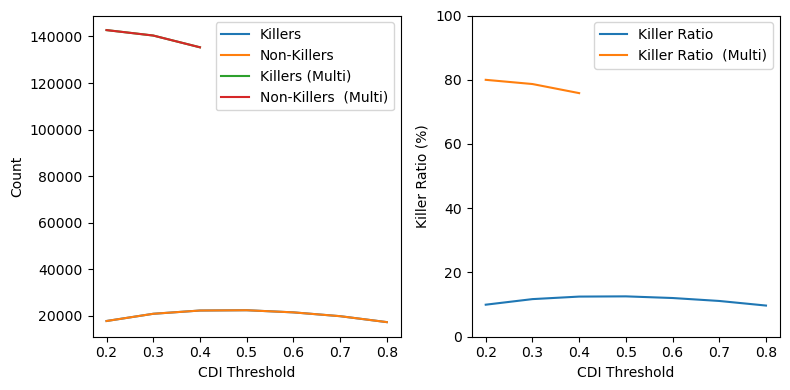

In [23]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

killer_count = {
    "CDI_thres": [],
    "killers": [],
    "non_killers": [],
    "killer_ratio": []
}

for i in tqdm(range(2,9,1)):
    cdi_thres = 0.1*i
    killers = len(tcell_with_kill[cdi_thres][tcell_with_kill[cdi_thres]["kill"]]["track_id"].unique())
    non_killers = len(tcell_with_kill[cdi_thres]["track_id"].unique()) - killers
    killer_ratio = killers/(killers+non_killers)*100

    killer_count["CDI_thres"].append(cdi_thres)
    killer_count["killers"].append(killers)
    killer_count["non_killers"].append(non_killers)
    killer_count["killer_ratio"].append(killer_ratio)

killer_count = pd.DataFrame.from_dict(killer_count)

axs[0].plot(killer_count["CDI_thres"],killer_count["killers"],label="Killers")
axs[0].plot(killer_count["CDI_thres"],killer_count["killers"],label="Non-Killers")
axs[1].plot(killer_count["CDI_thres"],killer_count["killer_ratio"],label="Killer Ratio")

####### Multi Killer #######
multi_killer_count = {
    "CDI_thres": [],
    "killers": [],
    "non_killers": [],
    "killer_ratio": []
}

for i in tqdm(range(2,5,1)):
    cdi_thres = 0.1*i
    killers = len(tcell_with_multi_kill[cdi_thres][tcell_with_multi_kill[cdi_thres]["kill"]]["track_id"].unique())
    non_killers = len(tcell_with_multi_kill[cdi_thres]["track_id"].unique()) - killers
    killer_ratio = killers/(killers+non_killers)*100

    multi_killer_count["CDI_thres"].append(cdi_thres)
    multi_killer_count["killers"].append(killers)
    multi_killer_count["non_killers"].append(non_killers)
    multi_killer_count["killer_ratio"].append(killer_ratio)

multi_killer_count = pd.DataFrame.from_dict(multi_killer_count)

axs[0].plot(multi_killer_count["CDI_thres"],multi_killer_count["killers"],label="Killers (Multi)")
axs[0].plot(multi_killer_count["CDI_thres"],multi_killer_count["killers"],label="Non-Killers  (Multi)")
axs[1].plot(multi_killer_count["CDI_thres"],multi_killer_count["killer_ratio"],label="Killer Ratio  (Multi)")

axs[0].set_xlabel("CDI Threshold")
axs[0].set_ylabel("Count")
axs[0].legend()

axs[1].set_xlabel("CDI Threshold")
axs[1].set_ylabel("Killer Ratio (%)")
axs[1].set_ylim(0,100)
axs[1].legend()

plt.tight_layout()

print("Killer Count")
print(killer_count)
print("Killer Count (Multi)")
print(multi_killer_count)

### Histogram of Killing Event Occurrence

Here we perform distribution measurements of killing event count per single T cell, together give a track duration normalized value **Killing Ratio**. The Killing Ratio indicates the probability of killing event happens over unit time, independent of track quality.

#### Single Killer

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:06<00:00,  1.11it/s]


Killing Statistics:
   cdi_thres      Mean  Median        SD  10%  90%
0        0.2  0.132701     0.0  0.481479  0.0  0.0
1        0.3  0.158398     0.0  0.534739  0.0  1.0
2        0.4  0.173678     0.0  0.578158  0.0  1.0
3        0.5  0.177315     0.0  0.595683  0.0  1.0
4        0.6  0.169123     0.0  0.582338  0.0  1.0
5        0.7  0.155747     0.0  0.556488  0.0  1.0
6        0.8  0.131401     0.0  0.493305  0.0  0.0
Killing Ratio Statistics:
   cdi_thres      Mean  Median        SD  10%       90%
0        0.2  0.385636     0.0  1.763665  0.0  0.000000
1        0.3  0.459828     0.0  1.936979  0.0  0.916031
2        0.4  0.491340     0.0  1.994045  0.0  1.155698
3        0.5  0.492081     0.0  2.017073  0.0  1.188119
4        0.6  0.463660     0.0  1.972040  0.0  1.040350
5        0.7  0.425281     0.0  1.905916  0.0  0.745342
6        0.8  0.357222     0.0  1.740477  0.0  0.000000


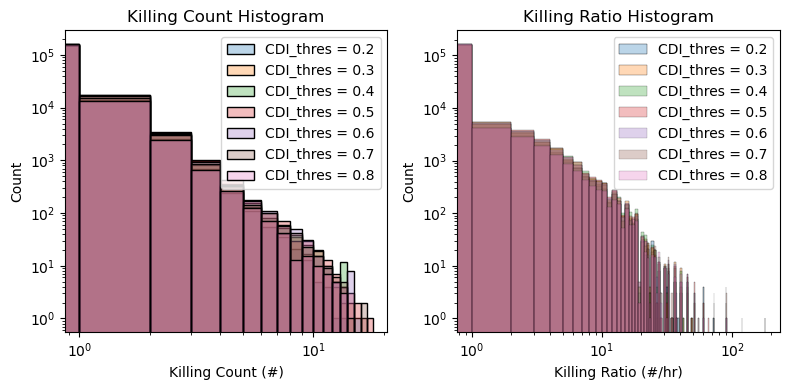

In [29]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

killing_stats = {
    "cdi_thres": [],
    "Mean": [],
    "Median": [],
    "SD":[],
    "10%": [],
    "90%": []
}

killing_ratio_stats = {
    "cdi_thres": [],
    "Mean": [],
    "Median": [],
    "SD":[],
    "10%": [],
    "90%": []
}

for i in tqdm(range(2,9,1)):
    cdi_thres = 0.1*i

    kill_count = tcell_with_kill[cdi_thres].groupby("track_id")["kill"].sum()
    track_len = tcell_with_kill[cdi_thres].groupby("track_id")["kill"].count()
    kill_ratio = kill_count/(track_len*10/3600)
    # axs.axvline(np.median(kill_count),c="k",label="Median")
    sns.histplot(kill_count,binwidth=1,label="CDI_thres = {:.1f}".format(cdi_thres),alpha=0.3, ax=axs[0])
    sns.histplot(kill_ratio,binwidth=1,label="CDI_thres = {:.1f}".format(cdi_thres),alpha=0.3, ax=axs[1])

    killing_stats["cdi_thres"].append(cdi_thres)
    killing_stats["Mean"].append(np.mean(kill_count))
    killing_stats["Median"].append(np.median(kill_count))
    killing_stats["SD"].append(np.std(kill_count))
    killing_stats["10%"].append(np.percentile(kill_count,10))
    killing_stats["90%"].append(np.percentile(kill_count,90))

    killing_ratio_stats["cdi_thres"].append(cdi_thres)
    killing_ratio_stats["Mean"].append(np.mean(kill_ratio))
    killing_ratio_stats["Median"].append(np.median(kill_ratio))
    killing_ratio_stats["SD"].append(np.std(kill_ratio))
    killing_ratio_stats["10%"].append(np.percentile(kill_ratio,10))
    killing_ratio_stats["90%"].append(np.percentile(kill_ratio,90))

axs[0].set_title("Killing Count Histogram")
axs[0].set_xlabel("Killing Count (#)")
axs[0].set_ylabel("Count")
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].legend()

axs[1].set_title("Killing Ratio Histogram")
axs[1].set_xlabel("Killing Ratio (#/hr)")
axs[1].set_ylabel("Count")
axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[1].legend()

plt.tight_layout()

killing_stats = pd.DataFrame.from_dict(killing_stats)
print("Killing Statistics:")
print(killing_stats)

killing_ratio_stats = pd.DataFrame.from_dict(killing_ratio_stats)
print("Killing Ratio Statistics:")
print(killing_ratio_stats)

#### Multi Killer

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Killing Statistics (Multi):
   cdi_thres       Mean  Median         SD  10%   90%
0        0.2  22.911477     9.0  50.511897  0.0  53.0
1        0.3  21.484809     9.0  49.003197  0.0  50.0
2        0.4  16.037022     6.0  38.519424  0.0  38.0
Killing Ratio Statistics (Multi):
   cdi_thres       Mean     Median         SD  10%         90%
0        0.2  62.725237  57.372759  50.214775  0.0  132.413793
1        0.3  58.038724  56.250000  46.987062  0.0  121.304348
2        0.4  43.280948  38.996222  38.533520  0.0   95.744681


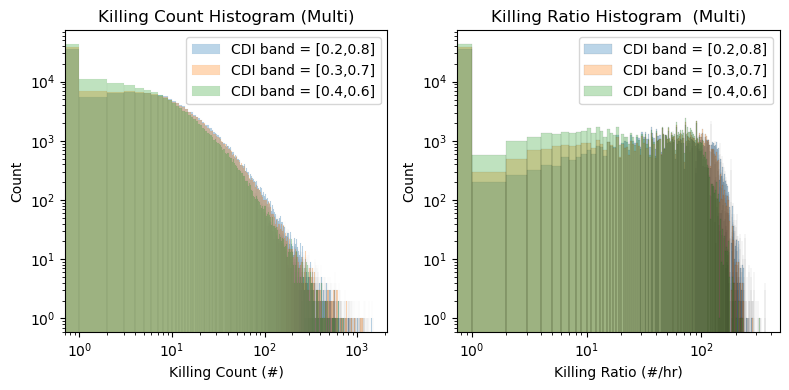

In [30]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

killing_stats_multi = {
    "cdi_thres": [],
    "Mean": [],
    "Median": [],
    "SD":[],
    "10%": [],
    "90%": []
}

killing_ratio_stats_multi = {
    "cdi_thres": [],
    "Mean": [],
    "Median": [],
    "SD":[],
    "10%": [],
    "90%": []
}

for i in tqdm(range(2,5,1)):
    cdi_thres = 0.1*i

    kill_count = tcell_with_multi_kill[cdi_thres].groupby("track_id")["kill"].sum()
    track_len = tcell_with_multi_kill[cdi_thres].groupby("track_id")["kill"].count()
    kill_ratio = kill_count/(track_len*10/3600)
    # axs.axvline(np.median(kill_count),c="k",label="Median")
    sns.histplot(kill_count,binwidth=1,label="CDI band = [{:.1f},{:.1f}]".format(cdi_thres,1-cdi_thres),alpha=0.3, ax=axs[0])
    sns.histplot(kill_ratio,binwidth=1,label="CDI band = [{:.1f},{:.1f}]".format(cdi_thres,1-cdi_thres),alpha=0.3, ax=axs[1])

    killing_stats_multi["cdi_thres"].append(cdi_thres)
    killing_stats_multi["Mean"].append(np.mean(kill_count))
    killing_stats_multi["Median"].append(np.median(kill_count))
    killing_stats_multi["SD"].append(np.std(kill_count))
    killing_stats_multi["10%"].append(np.percentile(kill_count,10))
    killing_stats_multi["90%"].append(np.percentile(kill_count,90))

    killing_ratio_stats_multi["cdi_thres"].append(cdi_thres)
    killing_ratio_stats_multi["Mean"].append(np.mean(kill_ratio))
    killing_ratio_stats_multi["Median"].append(np.median(kill_ratio))
    killing_ratio_stats_multi["SD"].append(np.std(kill_ratio))
    killing_ratio_stats_multi["10%"].append(np.percentile(kill_ratio,10))
    killing_ratio_stats_multi["90%"].append(np.percentile(kill_ratio,90))

axs[0].set_title("Killing Count Histogram (Multi)")
axs[0].set_xlabel("Killing Count (#)")
axs[0].set_ylabel("Count")
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].legend()

axs[1].set_title("Killing Ratio Histogram  (Multi)")
axs[1].set_xlabel("Killing Ratio (#/hr)")
axs[1].set_ylabel("Count")
axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[1].legend()

plt.tight_layout()

killing_stats_multi = pd.DataFrame.from_dict(killing_stats_multi)
print("Killing Statistics (Multi):")
print(killing_stats_multi)

killing_ratio_stats_multi = pd.DataFrame.from_dict(killing_ratio_stats_multi)
print("Killing Ratio Statistics (Multi):")
print(killing_ratio_stats_multi)